
# Data Loading Section

In [ ]:
# import important libraries
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from math import floor
import os
import torchvision.models

use_cuda = True #enable usage of cuda GPU

In [ ]:
# Mount google drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# Loading the data 
#Toby's file directory paths (Note the MyDrive)
!unzip '/content/gdrive/MyDrive/APS360 Group Project/Data/zipped_data/test.zip' -d '/root/datasets'
!unzip '/content/gdrive/MyDrive/APS360 Group Project/Data/zipped_data/train.zip' -d '/root/datasets'
!unzip '/content/gdrive/MyDrive/APS360 Group Project/Data/zipped_data/val.zip' -d '/root/datasets'
!unzip '/content/gdrive/MyDrive/APS360 Group Project/Data/zipped_data/tiny.zip' -d '/root/datasets'



Archive:  /content/gdrive/MyDrive/APS360 Group Project/Data/zipped_data/test.zip
  inflating: /root/datasets/test/compost_other/O_2130.jpg  
  inflating: /root/datasets/test/compost_other/compost_tampons (18).jpg  
  inflating: /root/datasets/test/compost_other/O_5547.jpg  
  inflating: /root/datasets/test/compost_other/O_2511.jpg  
  inflating: /root/datasets/test/compost_other/O_2060.jpg  
  inflating: /root/datasets/test/garbage/more_wrap (3).jpg  
  inflating: /root/datasets/test/compost_other/O_2891.jpg  
  inflating: /root/datasets/test/compost_other/gbg_wrappers_papertowels (48).jpg  
  inflating: /root/datasets/test/compost_other/O_2674.jpg  
  inflating: /root/datasets/test/compost_other/O_2610.jpg  
  inflating: /root/datasets/test/garbage/gbgblackplastic (45).jpg  
  inflating: /root/datasets/test/compost_other/download (2).jpg  
  inflating: /root/datasets/test/compost_other/images (17).jpg  
  inflating: /root/datasets/test/garbage/gbg_wrappers_papertowels (83).jpg  
  inf

In [ ]:
# Loading the data
# Everyone else's file directory paths (Note the SharedDrive)
!unzip '/content/gdrive/Shareddrives/APS360 Group Project/Data/zipped_data/test.zip' -d '/root/datasets'
!unzip '/content/gdrive/Shareddrives/APS360 Group Project/Data/zipped_data/train.zip' -d '/root/datasets'
!unzip '/content/gdrive/Shareddrives/APS360 Group Project/Data/zipped_data/val.zip' -d '/root/datasets'
!unzip '/content/gdrive/Shareddrives/APS360 Group Project/Data/zipped_data/tiny.zip' -d '/root/datasets'


In [ ]:
train_path = '/root/datasets/train'
val_path = '/root/datasets/val'
test_path = '/root/datasets/test'
tiny_path = '/root/datasets/tiny'

In [ ]:
# Load the tensors
transformations = transforms.Compose([                                     
  transforms.Resize((224,224)),
  transforms.ToTensor(),
  transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  
])
train_set = torchvision.datasets.ImageFolder(train_path, transform = transformations)
val_set = torchvision.datasets.ImageFolder(val_path, transform = transformations)
test_set = torchvision.datasets.ImageFolder(test_path, transform = transformations)
tiny_set = torchvision.datasets.ImageFolder(tiny_path, transform = transformations)

# Model and Training Functions and Classes

In [ ]:
'''
Functions for training and getting accuracy
'''
def train(model, train_set, val_set, batch_size=64, num_epochs=1, learning_rate=0.001):
  iters = np.zeros(num_epochs)
  losses = np.zeros(num_epochs)
  train_acc = np.zeros(num_epochs)
  val_acc = np.zeros(num_epochs)

  # Fixed PyTorch random seed for reproducible result
  torch.manual_seed(1000)

  train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, num_workers=1)#, shuffle=True)
  val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, num_workers=1)#, shuffle=True)

  #use Cross entropy loss and Stochastic gradient descent
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

  # training
  n = 0 # the number of iterations
  for epoch in range(num_epochs):
      for i, data in enumerate(train_loader, 0):
          imgs, labels = data 
        
          #############################################
          #To Enable GPU Usage
          if use_cuda and torch.cuda.is_available():
            imgs = imgs.cuda()
            labels = labels.cuda()
          #############################################
          
            
          out = model(imgs)             # forward pass
          loss = criterion(out, labels) # compute the total loss
          loss.backward()               # backward pass (compute parameter updates)
          optimizer.step()              # make the updates for each parameter
          optimizer.zero_grad()         # a clean up step for PyTorch
          n += 1

      # save the current training information
      iters[epoch] = epoch 
      losses[epoch] = (float(loss)/batch_size)             # compute *average* loss
      train_acc[epoch] = get_accuracy(model, train_loader) # compute training accuracy 
      val_acc[epoch] = get_accuracy(model, val_loader)  # compute validation accuracy

          
          

      #printing out data
      print(("Epoch {}: Train accuracy: {}, Training Loss: {}, Validation Accuracy: {}").format(
                  epoch + 1,
                  train_acc[epoch],
                  losses[epoch],
                  val_acc[epoch]))

      # Save the current model (checkpoint) to a file
      model_path = get_model_name(model.name, batch_size, learning_rate, epoch)
      torch.save(model.state_dict(), model_path)


  # plotting
  plt.title("Training Curve")
  plt.plot(iters, losses, label="Train")
  plt.xlabel("Iterations")
  plt.ylabel("Loss")
  plt.show()

  plt.title("Training Curve")
  plt.plot(iters, train_acc, label="Train")
  plt.plot(iters, val_acc, label="Validation")
  plt.xlabel("Iterations")
  plt.ylabel("Training Accuracy")
  plt.legend(loc='best')
  plt.show()

  print("Final Training Accuracy: {}".format(train_acc[-1]))
  print("Final Validation Accuracy: {}".format(val_acc[-1]))

# calculates accuracy
def get_accuracy(model, loader):
  correct = 0
  total = 0
  for imgs, labels in loader:    
      #############################################
      #To Enable GPU Usage
      if use_cuda and torch.cuda.is_available():
        imgs = imgs.cuda()
        labels = labels.cuda()
      #############################################        
      output = model(imgs)
      
      #select index with maximum prediction score
      pred = output.max(1, keepdim=True)[1]
      correct += pred.eq(labels.view_as(pred)).sum().item()
      total += imgs.shape[0]
  return correct / total

def get_accuracy_of_label(model, loader, label):
  correct = 0
  total = 0
  for imgs, labels in loader:    
      #############################################
      #To Enable GPU Usage
      if use_cuda and torch.cuda.is_available():
        imgs = imgs.cuda()
        labels = labels.cuda()
      #############################################        
      output = model(imgs)
      
      #select index with maximum prediction score
      pred = output.max(1, keepdim=True)[1]
      correct += pred.eq(labels.view_as(pred)).sum().item()
      total += imgs.shape[0]
  return correct / total

def get_model_name(name, batch_size, learning_rate, epoch):
  """ Generate a name for the model consisting of all the hyperparameter values

  Args:
      config: Configuration object containing the hyperparameters
  Returns:
      path: A string with the hyperparameter name and value concatenated
  """
  path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                  batch_size,
                                                  learning_rate,
                                                  epoch)
  return path  

In [ ]:
# Models for transfer learning
resnet18 = torchvision.models.resnet18(pretrained=True)
alexnet = torchvision.models.alexnet(pretrained=True)
googlenet = torchvision.models.googlenet(pretrained=True)
resnet152 = torchvision.models.resnet152(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-4df8aa71.pth


Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth


Downloading: "https://download.pytorch.org/models/resnet152-b121ed2d.pth" to /root/.cache/torch/hub/checkpoints/resnet152-b121ed2d.pth


In [ ]:
# function to transfer learning model features as tensors into folder
def save_features(model, model_name, dataset, directory, classes):
  '''
  model: the chosen transfer learning model
  directory: This is the directory where we want to save the tensors
  dataset: pass in tensor dataset
  classes: pass in array of list of classes'''
  

  loader = torch.utils.data.DataLoader(dataset, batch_size=1, num_workers=1)
  os.mkdir(directory)

  n = 0 # use this to track the number of the file
  for imgs, labels in loader:
    # extract features and save as tensors
    features = model(imgs)
    tensor_features = torch.from_numpy(features.detach().numpy())

    #create the class directory if it doesn't exist
    if (not os.path.exists(directory + '/' + classes[labels])):
      os.mkdir(directory + '/' + classes[labels])

    #save tensor file as a file
    #can be saved as a .pt file: https://pytorch.org/docs/stable/generated/torch.save.html
    torch.save(tensor_features.squeeze(0), directory + '/' + classes[labels] + '/' + model_name + '_' + str(n) + '.pt')

    n = n+1

In [ ]:
class Waste_Classifier_ANN(nn.Module):
  def __init__(self, name="WasteNet", hidden_size=256*6*6):
    super(Waste_Classifier_ANN, self).__init__()
    self.name = name
    self.fc1 = nn.Linear(hidden_size, 50)
    self.fc2 = nn.Linear(50, 10)
    self.hidden_size = hidden_size

  def forward(self, x):
    x = x.view(-1, self.hidden_size) #flatten feature data
    x = F.relu(self.fc1(x))
    x = self.fc2(x)
    return x

In [ ]:
class Waste_Classifier_MLP(nn.Module):
  def __init__(self, name="WasteNet", hidden_size=256*6*6):
    super(Waste_Classifier_MLP, self).__init__()
    self.name = name
    self.fc1 = nn.Linear(hidden_size, 50)
    self.fc2 = nn.Linear(50, 30)
    self.fc3 = nn.Linear(30, 10)
    self.hidden_size = hidden_size

  def forward(self, x):
    #print(x.shape)
    x = x.view(-1, self.hidden_size) #flatten feature data
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    return x

# Predictions and Testing --> AlexNet

In [ ]:
# save Alex Net features first: Trying this model first
data_dir = '/root/datasets/AlexNet/'
train_dir = data_dir + 'train/'
val_dir = data_dir + 'val/'
test_dir = data_dir + 'test/'
tiny_dir = data_dir + 'tiny/'

os.mkdir(data_dir)
model = alexnet.features
save_features(model, "alexnet", tiny_set, tiny_dir, tiny_set.classes)
save_features(model, "alexnet", train_set, train_dir, train_set.classes)
save_features(model, "alexnet", val_set, val_dir, val_set.classes)
save_features(model, "alexnet", test_set, test_dir, test_set.classes)


In [ ]:
feature_tiny_set = torchvision.datasets.DatasetFolder(tiny_dir, loader=torch.load, extensions=('.pt'))
feature_train_set = torchvision.datasets.DatasetFolder(train_dir, loader=torch.load, extensions=('.pt'))
feature_val_set = torchvision.datasets.DatasetFolder(val_dir, loader=torch.load, extensions=('.pt'))
feature_test_set = torchvision.datasets.DatasetFolder(test_dir, loader=torch.load, extensions=('.pt'))

Epoch 1: Train accuracy: 0.26666666666666666, Training Loss: 0.07695200443267822, Validation Accuracy: 0.26666666666666666
Epoch 2: Train accuracy: 0.43333333333333335, Training Loss: 0.07317289511362711, Validation Accuracy: 0.43333333333333335
Epoch 3: Train accuracy: 0.8, Training Loss: 0.06731022993723551, Validation Accuracy: 0.8
Epoch 4: Train accuracy: 0.9333333333333333, Training Loss: 0.060487449169158936, Validation Accuracy: 0.9333333333333333
Epoch 5: Train accuracy: 0.9333333333333333, Training Loss: 0.053065943717956546, Validation Accuracy: 0.9333333333333333
Epoch 6: Train accuracy: 0.9333333333333333, Training Loss: 0.045085410277048744, Validation Accuracy: 0.9333333333333333
Epoch 7: Train accuracy: 0.9333333333333333, Training Loss: 0.037086459000905354, Validation Accuracy: 0.9333333333333333
Epoch 8: Train accuracy: 0.9666666666666667, Training Loss: 0.029751022656758625, Validation Accuracy: 0.9666666666666667
Epoch 9: Train accuracy: 1.0, Training Loss: 0.023398

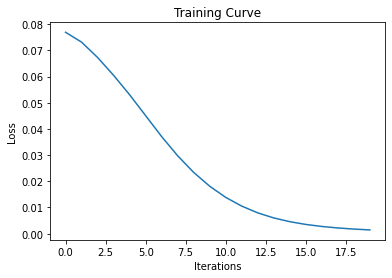

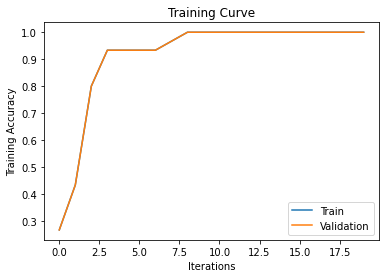

Final Training Accuracy: 1.0
Final Validation Accuracy: 1.0


In [ ]:
#Testing if I can overfit with Alex Net
alexNetClassify = Waste_Classifier_ANN(name="Waste_AlexNet")
if use_cuda and torch.cuda.is_available():
  alexNetClassify = alexNetClassify.cuda()
train(alexNetClassify, feature_tiny_set, feature_tiny_set, batch_size=30, num_epochs=20, learning_rate=0.002)

Epoch 1: Train accuracy: 0.10965848452508005, Training Loss: 0.018743792548775673, Validation Accuracy: 0.10897435897435898
Epoch 2: Train accuracy: 0.10939167556029883, Training Loss: 0.01851542294025421, Validation Accuracy: 0.10897435897435898
Epoch 3: Train accuracy: 0.10885805763073639, Training Loss: 0.018370766192674637, Validation Accuracy: 0.12393162393162394
Epoch 4: Train accuracy: 0.08911419423692636, Training Loss: 0.01829303428530693, Validation Accuracy: 0.09188034188034189
Epoch 5: Train accuracy: 0.13660618996798293, Training Loss: 0.018264027312397957, Validation Accuracy: 0.1282051282051282
Epoch 6: Train accuracy: 0.17849519743863393, Training Loss: 0.017810843884944916, Validation Accuracy: 0.1581196581196581
Epoch 7: Train accuracy: 0.14300960512273211, Training Loss: 0.017581460997462273, Validation Accuracy: 0.13675213675213677
Epoch 8: Train accuracy: 0.14701173959445038, Training Loss: 0.01744789630174637, Validation Accuracy: 0.13675213675213677
Epoch 9: Trai

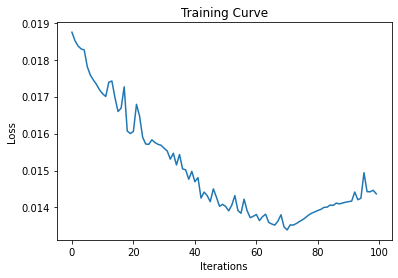

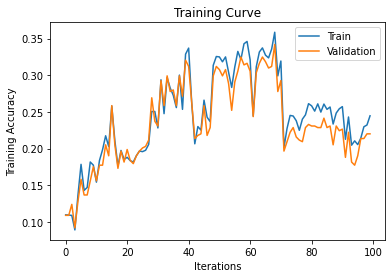

Final Training Accuracy: 0.24466382070437567
Final Validation Accuracy: 0.22008547008547008


In [ ]:
#Do Training with AlexNet
alexNetClassify = Waste_Classifier_ANN(name="Waste_AlexNet")
if use_cuda and torch.cuda.is_available():
  alexNetClassify = alexNetClassify.cuda()
train(alexNetClassify, feature_train_set, feature_val_set, batch_size=128, num_epochs=100, learning_rate=0.002)

Epoch 1: Train accuracy: 0.1376734258271078, Training Loss: 0.018297206610441208, Validation Accuracy: 0.14102564102564102
Epoch 2: Train accuracy: 0.05496264674493063, Training Loss: 0.018605642020702362, Validation Accuracy: 0.04487179487179487
Epoch 3: Train accuracy: 0.1376734258271078, Training Loss: 0.018509071320295334, Validation Accuracy: 0.14102564102564102
Epoch 4: Train accuracy: 0.217982924226254, Training Loss: 0.018029946833848953, Validation Accuracy: 0.2222222222222222
Epoch 5: Train accuracy: 0.1923692636072572, Training Loss: 0.01765989512205124, Validation Accuracy: 0.19658119658119658
Epoch 6: Train accuracy: 0.21211312700106724, Training Loss: 0.0174824558198452, Validation Accuracy: 0.1987179487179487
Epoch 7: Train accuracy: 0.2929562433297759, Training Loss: 0.017423495650291443, Validation Accuracy: 0.3141025641025641
Epoch 8: Train accuracy: 0.35965848452508004, Training Loss: 0.01714729517698288, Validation Accuracy: 0.35683760683760685
Epoch 9: Train accura

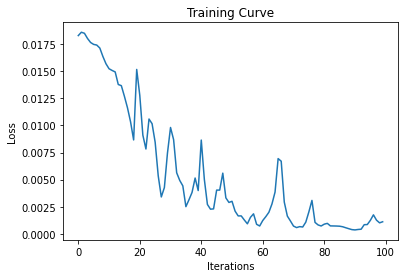

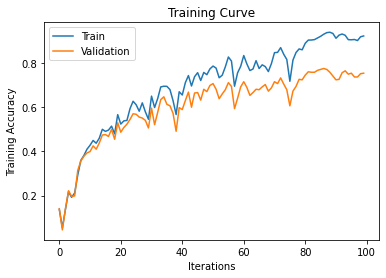

Final Training Accuracy: 0.9228922091782283
Final Validation Accuracy: 0.7542735042735043


In [ ]:
alexNetClassify = Waste_Classifier_MLP(name="Waste_AlexNetMLP")
if use_cuda and torch.cuda.is_available():
  alexNetClassify = alexNetClassify.cuda()
train(alexNetClassify, feature_train_set, feature_val_set, batch_size=128, num_epochs=100, learning_rate=0.002)

# Predictions and Testing --> ResNet18

In [ ]:
# set up the ResNet18 model
# ResNet18 Sample Tutorial: https://www.coursera.org/lecture/ai-deep-learning-capstone/pre-trained-models-with-resnet-18-review-pytorch-F0nDe
# 
model = resnet18
model = nn.Sequential(*(list(resnet18.children())[0:8]))
model

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

In [ ]:
# Save resnet18 features
data_dir = '/root/datasets/ResNet/'
train_dir = data_dir + 'train/'
val_dir = data_dir + 'val/'
test_dir = data_dir + 'test/'
tiny_dir = data_dir + 'tiny/'

os.mkdir(data_dir)
save_features(model, "ResNet", tiny_set, tiny_dir, tiny_set.classes)
save_features(model, "ResNet", train_set, train_dir, train_set.classes)
save_features(model, "ResNet", val_set, val_dir, val_set.classes)
save_features(model, "ResNet", test_set, test_dir, test_set.classes)
feature_tiny_set = torchvision.datasets.DatasetFolder(tiny_dir, loader=torch.load, extensions=('.pt'))
feature_train_set = torchvision.datasets.DatasetFolder(train_dir, loader=torch.load, extensions=('.pt'))
feature_val_set = torchvision.datasets.DatasetFolder(val_dir, loader=torch.load, extensions=('.pt'))
feature_test_set = torchvision.datasets.DatasetFolder(test_dir, loader=torch.load, extensions=('.pt'))

Epoch 1: Train accuracy: 0.2, Training Loss: 0.1575339476267497, Validation Accuracy: 0.2
Epoch 2: Train accuracy: 0.3, Training Loss: 0.14707935651143392, Validation Accuracy: 0.3
Epoch 3: Train accuracy: 0.5666666666666667, Training Loss: 0.13523136774698893, Validation Accuracy: 0.5666666666666667
Epoch 4: Train accuracy: 0.7, Training Loss: 0.12073891162872315, Validation Accuracy: 0.7
Epoch 5: Train accuracy: 0.8, Training Loss: 0.10451228618621826, Validation Accuracy: 0.8
Epoch 6: Train accuracy: 0.9, Training Loss: 0.08806579113006592, Validation Accuracy: 0.9
Epoch 7: Train accuracy: 0.9333333333333333, Training Loss: 0.07128074963887533, Validation Accuracy: 0.9333333333333333
Epoch 8: Train accuracy: 0.9333333333333333, Training Loss: 0.05559222300847371, Validation Accuracy: 0.9333333333333333
Epoch 9: Train accuracy: 0.9333333333333333, Training Loss: 0.04185106754302979, Validation Accuracy: 0.9333333333333333
Epoch 10: Train accuracy: 0.9333333333333333, Training Loss: 0

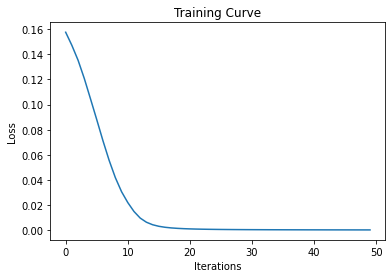

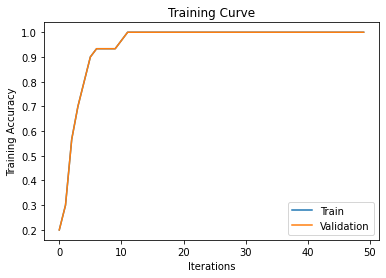

Final Training Accuracy: 1.0
Final Validation Accuracy: 1.0


In [ ]:
#Testing if I can overfit with ResNet
resNetClassify = Waste_Classifier_MLP(name="Waste_ResNet", hidden_size=512*7*7)
if use_cuda and torch.cuda.is_available():
  resNetClassify = resNetClassify.cuda()
train(resNetClassify, feature_tiny_set, feature_tiny_set, batch_size=15, num_epochs=50, learning_rate=0.001)

Epoch 1: Train accuracy: 0.10779082177161152, Training Loss: 0.009663347154855728, Validation Accuracy: 0.10897435897435898
Epoch 2: Train accuracy: 0.10538954108858058, Training Loss: 0.020480217412114143, Validation Accuracy: 0.1047008547008547
Epoch 3: Train accuracy: 0.10965848452508005, Training Loss: 0.01992233656346798, Validation Accuracy: 0.10897435897435898
Epoch 4: Train accuracy: 0.11152614727854857, Training Loss: 0.018677853047847748, Validation Accuracy: 0.1111111111111111
Epoch 5: Train accuracy: 0.11205976520811099, Training Loss: 0.018567122519016266, Validation Accuracy: 0.1111111111111111
Epoch 6: Train accuracy: 0.11446104589114195, Training Loss: 0.018464645370841026, Validation Accuracy: 0.1111111111111111
Epoch 7: Train accuracy: 0.11019210245464248, Training Loss: 0.018357746303081512, Validation Accuracy: 0.10897435897435898
Epoch 8: Train accuracy: 0.11339381003201708, Training Loss: 0.01825924590229988, Validation Accuracy: 0.1111111111111111
Epoch 9: Train 

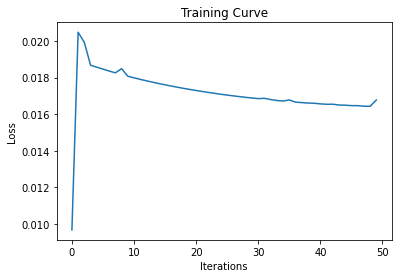

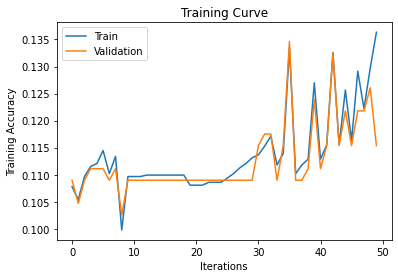

Final Training Accuracy: 0.1363393810032017
Final Validation Accuracy: 0.11538461538461539


In [ ]:
resNetClassify1 = Waste_Classifier_MLP(name="Waste_ResNet1", hidden_size=512*7*7)
if use_cuda and torch.cuda.is_available():
  resNetClassify1 = resNetClassify1.cuda()
train(resNetClassify1, feature_train_set, feature_val_set, batch_size=128, num_epochs=50, learning_rate=0.001)

# Predictions and Testing --> Inception

Got up to 89% accuracy.

In [ ]:
inception = torchvision.models.inception_v3(pretrained=True)

In [ ]:
# Load the tensors
transformations_inception = transforms.Compose([                                     
  transforms.Resize((299,299)),
  transforms.ToTensor(),
  transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  
])
train_set_inception = torchvision.datasets.ImageFolder(train_path, transform=transformations_inception)
val_set_inception = torchvision.datasets.ImageFolder(val_path, transform=transformations_inception)
test_set_inception = torchvision.datasets.ImageFolder(test_path, transform=transformations_inception)
tiny_set_inception = torchvision.datasets.ImageFolder(tiny_path, transform=transformations_inception)

In [ ]:
inception.fc = nn.Identity()
inception.eval()

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

In [ ]:
# save inception features
data_dir = '/root/datasets/Inception/'
train_dir = data_dir + 'train/'
val_dir = data_dir + 'val/'
test_dir = data_dir + 'test/'
tiny_dir = data_dir + 'tiny/'

# os.mkdir(data_dir)
model = inception
save_features(model, "inception", tiny_set_inception, tiny_dir, tiny_set_inception.classes)
save_features(model, "inception", train_set_inception, train_dir, train_set_inception.classes)
save_features(model, "inception", val_set_inception, val_dir, val_set_inception.classes)
save_features(model, "inception", test_set_inception, test_dir, test_set_inception.classes)


In [ ]:
feature_tiny_set_inception = torchvision.datasets.DatasetFolder(tiny_dir, loader=torch.load, extensions=('.pt'))
feature_train_set_inception = torchvision.datasets.DatasetFolder(train_dir, loader=torch.load, extensions=('.pt'))
feature_val_set_inception = torchvision.datasets.DatasetFolder(val_dir, loader=torch.load, extensions=('.pt'))
feature_test_set_inception = torchvision.datasets.DatasetFolder(test_dir, loader=torch.load, extensions=('.pt'))

Epoch 1: Train accuracy: 0.03333333333333333, Training Loss: 0.07745150725046794, Validation Accuracy: 0.03333333333333333
Epoch 2: Train accuracy: 0.03333333333333333, Training Loss: 0.07734755674997966, Validation Accuracy: 0.03333333333333333
Epoch 3: Train accuracy: 0.03333333333333333, Training Loss: 0.07715221246083577, Validation Accuracy: 0.03333333333333333
Epoch 4: Train accuracy: 0.06666666666666667, Training Loss: 0.07687731583913167, Validation Accuracy: 0.06666666666666667
Epoch 5: Train accuracy: 0.1, Training Loss: 0.07652969360351562, Validation Accuracy: 0.1
Epoch 6: Train accuracy: 0.13333333333333333, Training Loss: 0.07612125873565674, Validation Accuracy: 0.13333333333333333
Epoch 7: Train accuracy: 0.2, Training Loss: 0.0756756067276001, Validation Accuracy: 0.2
Epoch 8: Train accuracy: 0.3, Training Loss: 0.07519900798797607, Validation Accuracy: 0.3
Epoch 9: Train accuracy: 0.4, Training Loss: 0.07469326655069987, Validation Accuracy: 0.4
Epoch 10: Train accura

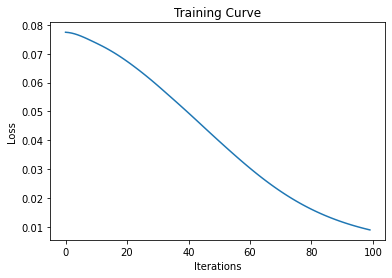

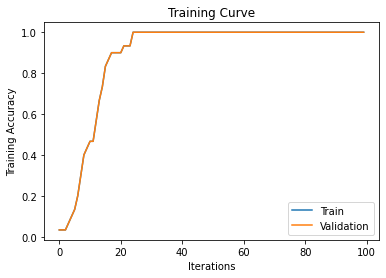

Final Training Accuracy: 1.0
Final Validation Accuracy: 1.0


In [ ]:
#Testing if I can overfit with Inception
inceptionClassify = Waste_Classifier_ANN(name="Waste_Inception", hidden_size=2048)
if use_cuda and torch.cuda.is_available():
  inceptionClassify = inceptionClassify.cuda()
train(inceptionClassify, feature_tiny_set_inception, feature_tiny_set_inception, batch_size=30, num_epochs=100, learning_rate=0.002)

In [ ]:
inceptionClassify = Waste_Classifier_ANN(name="Waste_InceptionANN", hidden_size=2048)
if use_cuda and torch.cuda.is_available():
  inceptionClassify = inceptionClassify.cuda()
train(inceptionClassify, feature_train_set_inception, feature_val_set_inception, batch_size=128, num_epochs=200, learning_rate=0.002)

Epoch 1: Train accuracy: 0.18996798292422626, Training Loss: 0.019606580957770348, Validation Accuracy: 0.17307692307692307
Epoch 2: Train accuracy: 0.16568836712913554, Training Loss: 0.01873674988746643, Validation Accuracy: 0.17735042735042736
Epoch 3: Train accuracy: 0.24946638207043756, Training Loss: 0.018812483176589012, Validation Accuracy: 0.2329059829059829
Epoch 4: Train accuracy: 0.25933831376734257, Training Loss: 0.018639596179127693, Validation Accuracy: 0.25213675213675213
Epoch 5: Train accuracy: 0.30389541088580574, Training Loss: 0.017276188358664513, Validation Accuracy: 0.31837606837606836
Epoch 6: Train accuracy: 0.36312700106723583, Training Loss: 0.01730886846780777, Validation Accuracy: 0.37606837606837606
Epoch 7: Train accuracy: 0.422358591248666, Training Loss: 0.016573091968894005, Validation Accuracy: 0.4166666666666667
Epoch 8: Train accuracy: 0.5146744930629669, Training Loss: 0.01618642359972, Validation Accuracy: 0.5213675213675214
Epoch 9: Train accur

Exception ignored in: <function WeakValueDictionary.__init__.<locals>.remove at 0x7fdb858293b0>
Traceback (most recent call last):
  File "/usr/lib/python3.7/weakref.py", line 109, in remove
    def remove(wr, selfref=ref(self), _atomic_removal=_remove_dead_weakref):
KeyboardInterrupt


Epoch 120: Train accuracy: 0.9743863393810032, Training Loss: 0.00030791189055889845, Validation Accuracy: 0.8931623931623932
Epoch 121: Train accuracy: 0.9749199573105657, Training Loss: 0.00030642864294350147, Validation Accuracy: 0.8931623931623932
Epoch 122: Train accuracy: 0.9751867662753468, Training Loss: 0.0003012650413438678, Validation Accuracy: 0.8888888888888888
Epoch 123: Train accuracy: 0.9762540021344717, Training Loss: 0.00029478961369022727, Validation Accuracy: 0.8910256410256411


KeyboardInterrupt: ignored

Epoch 1: Train accuracy: 0.12860192102454643, Training Loss: 0.018631301820278168, Validation Accuracy: 0.13247863247863248
Epoch 2: Train accuracy: 0.1536819637139808, Training Loss: 0.018326394259929657, Validation Accuracy: 0.16666666666666666
Epoch 3: Train accuracy: 0.21611526147278548, Training Loss: 0.018218310549855232, Validation Accuracy: 0.22863247863247863
Epoch 4: Train accuracy: 0.327641408751334, Training Loss: 0.017844485118985176, Validation Accuracy: 0.33547008547008544
Epoch 5: Train accuracy: 0.37593383137673425, Training Loss: 0.01758294552564621, Validation Accuracy: 0.3888888888888889
Epoch 6: Train accuracy: 0.4180896478121665, Training Loss: 0.01715194247663021, Validation Accuracy: 0.41239316239316237
Epoch 7: Train accuracy: 0.39354322305229456, Training Loss: 0.016708964481949806, Validation Accuracy: 0.405982905982906
Epoch 8: Train accuracy: 0.4426360725720384, Training Loss: 0.01598421484231949, Validation Accuracy: 0.452991452991453
Epoch 9: Train accura

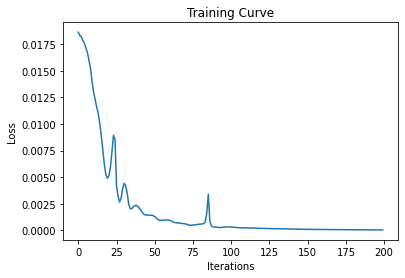

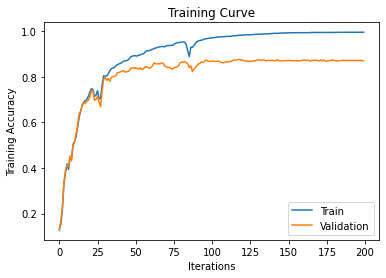

Final Training Accuracy: 0.9954642475987193
Final Validation Accuracy: 0.8696581196581197


In [ ]:
inceptionClassify = Waste_Classifier_MLP(name="Waste_InceptionMLP2", hidden_size=2048)
if use_cuda and torch.cuda.is_available():
  inceptionClassify = inceptionClassify.cuda()
train(inceptionClassify, feature_train_set_inception, feature_val_set_inception, batch_size=128, num_epochs=200, learning_rate=0.002)

# Predictions and Testing --> VGG16

In [ ]:
vgg16 = torchvision.models.vgg16(pretrained=True)
vgg16.classifier = nn.Identity()
vgg16.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
data_dir = '/root/datasets/VGG16/'
train_dir = data_dir + 'train/'
val_dir = data_dir + 'val/'
test_dir = data_dir + 'test/'
tiny_dir = data_dir + 'tiny/'

os.mkdir(data_dir)
model = vgg16
save_features(model, "vgg16", tiny_set, tiny_dir, tiny_set.classes)
save_features(model, "vgg16", train_set, train_dir, train_set.classes)
save_features(model, "vgg16", val_set, val_dir, val_set.classes)
save_features(model, "vgg16", test_set, test_dir, test_set.classes)

In [ ]:
feature_tiny_set_vgg16 = torchvision.datasets.DatasetFolder(tiny_dir, loader=torch.load, extensions=('.pt'))
feature_train_set_vgg16 = torchvision.datasets.DatasetFolder(train_dir, loader=torch.load, extensions=('.pt'))
feature_val_set_vgg16 = torchvision.datasets.DatasetFolder(val_dir, loader=torch.load, extensions=('.pt'))
feature_test_set_vgg16 = torchvision.datasets.DatasetFolder(test_dir, loader=torch.load, extensions=('.pt'))

Epoch 1: Train accuracy: 0.16666666666666666, Training Loss: 0.07910817464192708, Validation Accuracy: 0.16666666666666666
Epoch 2: Train accuracy: 0.43333333333333335, Training Loss: 0.07488875389099121, Validation Accuracy: 0.43333333333333335
Epoch 3: Train accuracy: 0.8, Training Loss: 0.06929771105448405, Validation Accuracy: 0.8
Epoch 4: Train accuracy: 0.9333333333333333, Training Loss: 0.06319302717844645, Validation Accuracy: 0.9333333333333333
Epoch 5: Train accuracy: 1.0, Training Loss: 0.055969858169555665, Validation Accuracy: 1.0
Epoch 6: Train accuracy: 1.0, Training Loss: 0.04799492756525676, Validation Accuracy: 1.0
Epoch 7: Train accuracy: 1.0, Training Loss: 0.039623486995697024, Validation Accuracy: 1.0
Epoch 8: Train accuracy: 1.0, Training Loss: 0.031514505545298256, Validation Accuracy: 1.0
Epoch 9: Train accuracy: 1.0, Training Loss: 0.024390508731206257, Validation Accuracy: 1.0
Epoch 10: Train accuracy: 1.0, Training Loss: 0.018466482559839886, Validation Accu

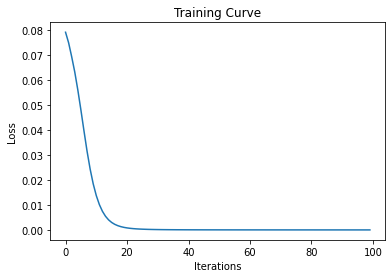

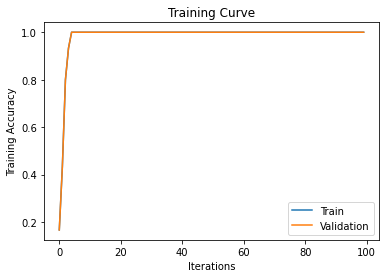

Final Training Accuracy: 1.0
Final Validation Accuracy: 1.0


In [ ]:
vgg16Classify = Waste_Classifier_ANN(name="Waste_VGG16", hidden_size=25088)
if use_cuda and torch.cuda.is_available():
  vgg16Classify = vgg16Classify.cuda()
train(vgg16Classify, feature_tiny_set_vgg16, feature_tiny_set_vgg16, batch_size=30, num_epochs=100, learning_rate=0.002)

Epoch 1: Train accuracy: 0.23559231590181431, Training Loss: 0.01843496784567833, Validation Accuracy: 0.24572649572649571
Epoch 2: Train accuracy: 0.3105656350053362, Training Loss: 0.01794353872537613, Validation Accuracy: 0.31196581196581197
Epoch 3: Train accuracy: 0.4981323372465315, Training Loss: 0.01748044788837433, Validation Accuracy: 0.48504273504273504
Epoch 4: Train accuracy: 0.5843116328708644, Training Loss: 0.016587041318416595, Validation Accuracy: 0.5555555555555556
Epoch 5: Train accuracy: 0.6486125933831377, Training Loss: 0.014840720221400261, Validation Accuracy: 0.6217948717948718
Epoch 6: Train accuracy: 0.6891675560298826, Training Loss: 0.012902353890240192, Validation Accuracy: 0.6709401709401709
Epoch 7: Train accuracy: 0.7169156883671292, Training Loss: 0.01139439269900322, Validation Accuracy: 0.6987179487179487
Epoch 8: Train accuracy: 0.7353255069370331, Training Loss: 0.01010880060493946, Validation Accuracy: 0.7094017094017094
Epoch 9: Train accuracy: 

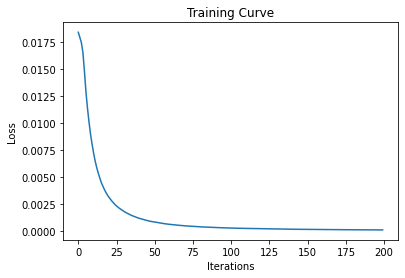

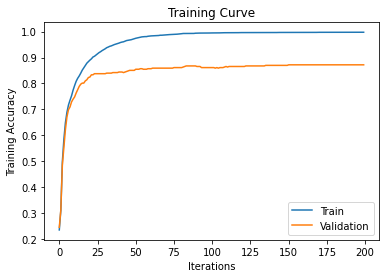

Final Training Accuracy: 0.9973319103521878
Final Validation Accuracy: 0.8717948717948718


In [ ]:
vgg16Classify = Waste_Classifier_ANN(name="Waste_VGG16", hidden_size=25088)
if use_cuda and torch.cuda.is_available():
  vgg16Classify = vgg16Classify.cuda()
train(vgg16Classify, feature_train_set_vgg16, feature_val_set_vgg16, batch_size=128, num_epochs=200, learning_rate=0.00025)

Epoch 1: Train accuracy: 0.20624332977588047, Training Loss: 0.07717180252075195, Validation Accuracy: 0.20512820512820512
Epoch 2: Train accuracy: 0.2676093916755603, Training Loss: 0.07647629082202911, Validation Accuracy: 0.2692307692307692
Epoch 3: Train accuracy: 0.3289754535752401, Training Loss: 0.07022517174482346, Validation Accuracy: 0.32051282051282054
Epoch 4: Train accuracy: 0.3783351120597652, Training Loss: 0.0648365393280983, Validation Accuracy: 0.37393162393162394
Epoch 5: Train accuracy: 0.3890074706510139, Training Loss: 0.05760527402162552, Validation Accuracy: 0.391025641025641
Epoch 6: Train accuracy: 0.4119530416221985, Training Loss: 0.052759602665901184, Validation Accuracy: 0.41452991452991456
Epoch 7: Train accuracy: 0.44957310565635006, Training Loss: 0.047910045832395554, Validation Accuracy: 0.4465811965811966
Epoch 8: Train accuracy: 0.4957310565635005, Training Loss: 0.043403301388025284, Validation Accuracy: 0.47435897435897434
Epoch 9: Train accuracy:

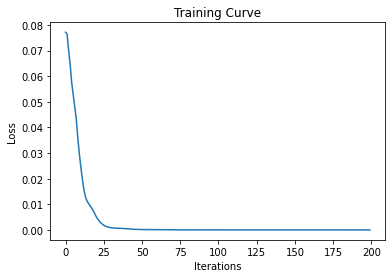

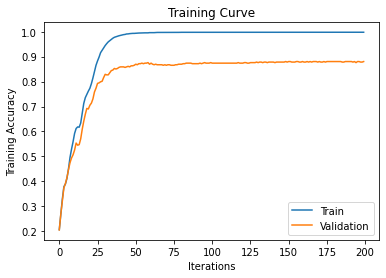

Final Training Accuracy: 0.9978655282817502
Final Validation Accuracy: 0.8803418803418803


In [ ]:
vgg16Classify = Waste_Classifier_MLP(name="Waste_VGG16", hidden_size=25088)
if use_cuda and torch.cuda.is_available():
  vgg16Classify = vgg16Classify.cuda()
train(vgg16Classify, feature_train_set_vgg16, feature_val_set_vgg16, batch_size=32, num_epochs=200, learning_rate=0.0003)

# Baseline Model: Random Forests

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
forest = RandomForestClassifier(n_estimators=200, bootstrap=True, max_features='sqrt')
loader = torch.utils.data.DataLoader(tiny_set, batch_size=len(tiny_set), num_workers=1)
accuracy = 0
total = 0

for imgs, labels in loader:
  imgs = imgs.numpy()
  labels = labels.numpy()
  imgs = imgs.reshape((imgs.shape[0], imgs.shape[1]*imgs.shape[2]*imgs.shape[3]))

  forest.fit(imgs, labels)
  predictions = forest.predict(imgs)

  accuracy += accuracy_score(predictions, labels)
  total += 1
print("Overfit accuracy:", accuracy/total)


Overfit accuracy: 1.0


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
forest = RandomForestClassifier(n_estimators=200, bootstrap=True, max_features='sqrt')
loader = torch.utils.data.DataLoader(train_set, batch_size=len(train_set), num_workers=1)
accuracy = 0
total = 0

for imgs, labels in loader:
  imgs = imgs.numpy()
  labels = labels.numpy()
  imgs = imgs.reshape((imgs.shape[0], imgs.shape[1]*imgs.shape[2]*imgs.shape[3]))
  forest.fit(imgs, labels)

  val_loader = torch.utils.data.DataLoader(val_set, batch_size=len(val_set), num_workers=1)
  for val_imgs, val_labels in val_loader:
    val_imgs = val_imgs.numpy()
    val_labels = val_labels.numpy()
    val_imgs = val_imgs.reshape((val_imgs.shape[0], val_imgs.shape[1]*val_imgs.shape[2]*val_imgs.shape[3]))
    predictions = forest.predict(val_imgs)
    accuracy += accuracy_score(predictions, val_labels)
    total += 1

print("Overfit accuracy:", accuracy/total)

Overfit accuracy: 0.5683760683760684
